In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from scipy.integrate import quad

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
#from suntimes import SunTimes  

In [ ]:
def train_test_ds_by_year(x_train, y_train, test_years = [2015, 2016, 2017], year_column = -2, train_proportion = 0.8):
    samples_in_test_years = torch.isin(x_train[:, year_column, 0], torch.Tensor(test_years))
    train_ds = TensorDataset(x_train[~samples_in_test_years, :, :], y_train[~samples_in_test_years, :])
    val_ds = TensorDataset(x_train[samples_in_test_years, :, :], y_train[samples_in_test_years, :])
    return train_ds, val_ds

def train_test_dl_by_year(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.8, test_years = [2015, 2016, 2017], year_column = -2):
    train_ds, val_ds = train_test_ds_by_year(x_train, y_train, train_proportion = train_proportion, test_years = test_years, year_column = year_column)
    train_dl = DataLoader(train_ds, batch_size=bs)
    val_dl = DataLoader(val_ds, batch_size=bs)
    train_dl = WrappedDataLoader(train_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    val_dl = WrappedDataLoader(val_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    return train_dl, val_dl

In [ ]:
def Wang_Engel_Integral(T, T_min, T_opt, T_max):
    alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
    f_1 = (2*(np.sign(T - T_min)*(T - T_min))**(alpha + 1))*((T_opt - T_min)**alpha) / (alpha + 1)
    f_2 = ((np.sign(T - T_min)*(T - T_min))**((2*alpha) + 1)) / ((2*alpha) + 1)
    f_T = ( f_1 - f_2 ) / ((T_opt - T_min)**(2*alpha))
    f_T = np.nan_to_num(f_T)

    f_1_max = (2*(T_max - T_min)**(alpha + 1))*((T_opt - T_min)**alpha) / (alpha + 1)
    f_2_max = ((T_max - T_min)**((2*alpha) + 1)) / ((2*alpha) + 1)
    f_T_max = ( f_1_max - f_2_max ) / ((T_opt - T_min)**(2*alpha))
    return f_T*(T >= T_min)*(T<= T_max) + f_T_max*(T > T_max)
    
def Convolved_Wang_Engel(T, T_min, T_opt, T_max, gap = 4):
    return (1/(2*gap))*(Wang_Engel_Integral(np.minimum(T + gap, T_max), T_min, T_opt, T_max) - Wang_Engel_Integral(np.maximum(T - gap, T_min), T_min, T_opt, T_max))#
    
def integrand(T, T_min, T_opt, T_max, d, s, gap):
    #return modelling_fctns.Wang_Engel_Temp_response(T, T_min, T_opt, T_max, beta = 1.5)*np.exp(-((T - d)**2)/(2*(s**2)))
    return Convolved_Wang_Engel(T, T_min, T_opt, T_max, gap = gap)*(1/np.sqrt(2*np.pi*(s**2)))*np.exp(-((T - d)**2)/(2*(s**2)))
    
def expint(T_min, T_opt, T_max, d, s, gap):
    return quad(integrand, T_min, T_max, args=(T_min, T_opt, T_max, d, s, gap))[0]
vec_expint = np.vectorize(expint)

In [ ]:
def make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, model, region, eval_method):
    error_df = pd.DataFrame({
        'model': [model],
        'region': [region],
        'evaluation method': [eval_method],
        'R2': [np.mean(R2s)],
        'Bias (obs minus modelled)': [np.mean(Biases)],
        'Variance': [np.mean(Variances)],
        'RMSE': [np.mean(RMSEs)],
        'STD': [np.mean(STDs)],
        'Corr': [np.mean(Corrs)],
        'Min': [np.mean(Mins)],
        'LQ': [np.mean(LQs)],
        'Median': [np.mean(Medians)],
        'UQ': [np.mean(UQs)],
        'Max': [np.mean(Maxs)]
    })
    return error_df

In [ ]:
def K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params = False, loss = 'NLL', CNN=False, bce=False, lr = 0.01, MMD=False, n_channels = 4, DTF = False, obs_method = False, custom_loss = None):
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train_ds)):
        print(f"Fold {fold + 1}")

        # Define the data loaders for the current fold
        train_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        val_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )

        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False

        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        comparison_frame = get_comparison_frame(savename_prefix + str(fold + 1), TS_model, val_dl, bce=bce, CNN=CNN, MMD=MMD, n_channels = n_channels, DTF = DTF, obs_method = obs_method)
        comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

        bias_model = comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)

    return loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [ ]:
def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False, MMD=False, n_channels = 4, DTF = False, obs_method = False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    list_logs = []
    list_observed = []
    list_stations = []
    list_years = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            list_years.append(xb[:, n_channels, 0])
            list_stations.append(xb[:, n_channels + 1, 0])
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    stations = torch.squeeze(torch.cat(list_stations))
    years = torch.squeeze(torch.cat(list_years))
    observed = torch.cat(list_observed)
    print(logs.shape, torch.cat(list_logs, dim=0).shape)
    if not(DTF):
        if bce:
            fitted = torch.round(logs)
        else:
            fitted = torch.argmax(logs, dim=2)
    if DTF:
        logs = torch.round(logs)
        observed_days = mindex_at_0(observed)
        observed_days = observed[:, 0]
        observed_days = 90 + 100 - observed[:, 90]
        if obs_method:
            fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
        else:
            fitted_days = mindex_at_0(logs)
            fitted_days = 90 + 100 - logs[:, 90]
            #fitted_days = logs[:, 90]
        print(torch.sum(fitted_days < 30), ' fits too small')
    else:
        L = fitted.shape[1]
        fitted_days = L - fitted.sum(dim=1)
        observed_days = L - observed.sum(dim=1)
    #print(stations.numpy().squeeze())
    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [ ]:
def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    list_logs = []
    list_observed = []
    list_stations = []
    list_years = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            list_years.append(xb[:, 4, 0])
            list_stations.append(xb[:, 5, 0])
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    stations = torch.squeeze(torch.cat(list_stations))
    years = torch.squeeze(torch.cat(list_years))
    if bce:
        fitted = torch.round(logs)
    else:
        fitted = torch.argmax(logs, dim=2)
    L = fitted.shape[1]
    fitted_days = L - fitted.sum(dim=1)
    observed = torch.cat(list_observed)
    observed_days = L - observed.sum(dim=1)
    #print(stations.numpy().squeeze())
    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [ ]:
class temp_response_learner(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(temp_response_learner, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.u0 = torch.nn.Parameter(torch.Tensor([0]))
        self.u1 = torch.nn.Parameter(torch.Tensor([0]))
        self.u2 = torch.nn.Parameter(torch.Tensor([0]))
        self.u3 = torch.nn.Parameter(torch.Tensor([0]))
        self.u4 = torch.nn.Parameter(torch.Tensor([0]))
        self.u5 = torch.nn.Parameter(torch.Tensor([1]))
        self.u6 = torch.nn.Parameter(torch.Tensor([1]))
        self.u7 = torch.nn.Parameter(torch.Tensor([1]))
        self.u8 = torch.nn.Parameter(torch.Tensor([1]))
        self.u9 = torch.nn.Parameter(torch.Tensor([1]))
        self.u10 = torch.nn.Parameter(torch.Tensor([1]))
        self.u11 = torch.nn.Parameter(torch.Tensor([1]))
        self.u12 = torch.nn.Parameter(torch.Tensor([1]))
        self.u13 = torch.nn.Parameter(torch.Tensor([1]))
        self.u14 = torch.nn.Parameter(torch.Tensor([1]))
        self.u15 = torch.nn.Parameter(torch.Tensor([1]))
        self.u16 = torch.nn.Parameter(torch.Tensor([1]))
        self.u17 = torch.nn.Parameter(torch.Tensor([0]))
        self.u18 = torch.nn.Parameter(torch.Tensor([0]))
        self.u19 = torch.nn.Parameter(torch.Tensor([0]))

        self.coeffs = [self.u0, self.u1, self.u2, self.u3, self.u4, self.u5, self.u6, self.u7, self.u8, self.u9, self.u10, self.u11, self.u12, self.u13, self.u14, self.u15, self.u16, self.u17, self.u18, self.u19]

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        
    def B_0(self, u):
        return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)

    def response(self, meantemp):
        resp = 0
        for i, coeff in enumerate(self.coeffs[:-3]):
            resp += torch.abs(coeff)*self.B_0(0.25*(meantemp - i*2))
        return resp
    def forward(self, x):
        # Apply Wang Engel
        T_min = 9 + 2*(torch.tanh(self.u1))
        T_opt = 28 + 3*(torch.tanh(self.u2))
        T_max = 39 + torch.tanh(self.u3)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(x.shape)
        #x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        x[:, :, 0] = self.response(x[:, :, 0])#( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        # Make cumulative
        out_space = torch.cumsum(x[:, :, 0], dim = 1) - self.p0 #self.u0*
        if self.input_dim >= 3:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        if self.output_dim == 1:
            out_scores = self.sig(out_space)
        return out_scores

In [ ]:
def subset_ds_from_tensors(x_train, y_train, train_proportion = 0.2):
    full_ds = TensorDataset(x_train, y_train)
    train_size = int(train_proportion * len(full_ds))
    val_size = int(len(full_ds) - (1/train_proportion - 1)*train_size)
    split_ds = random_split(full_ds, [train_size, train_size, train_size, train_size, val_size])
    return split_ds

def subset_dl_from_tensors(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.2):
    split_dl = []
    split_ds = subset_ds_from_tensors(x_train, y_train, train_proportion = train_proportion)
    for ds in split_ds:
        dl = DataLoader(ds, batch_size=bs)
        dl = WrappedDataLoader(dl, lambda x, y: preprocess(x, y, channels =n_channels))
        split_dl.append(dl)
    return split_dl

In [ ]:
skip = 1
numsteps = int(163 // skip)
ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024.csv')
ds_inputs_DE1[[f't2max at day {skip*n}' for n in range(numsteps)]] += -273.15
ds_inputs_DE1[[f't2min at day {skip*n}' for n in range(numsteps)]] += -273.15
ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')
ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
new_series = []
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    #if variable_name != 't2m' and variable_name != 'photoperiod':
    #    scaler = StandardScaler()
    #    scaler.fit(data)
    #    data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'].values for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)

26213
26213


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_18856\44480070.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_dd5ga5p9x7\croot\libtorch_1746637520098\work\torch\csrc\utils\tensor_new.cpp:281.)
  year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T


In [ ]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008.csv')
#ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_SSA=ds_inputs_SSA.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_SSA))
ds_inputs_SSA = ds_inputs_SSA.dropna(how='all')
print(len(ds_inputs_SSA))
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 140]
skip = 1
numsteps = int(163 // skip)
new_series = []
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp', 't2max', 't2min'
    data = ds_inputs_SSA[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    if variable_name != 't2m' and variable_name != 'photoperiod':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_SSA = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((*new_series, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
ds_inputs_SSA.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_SSA['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_SSA),1))
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_SSA = 100 - torch.Tensor(ds_inputs_SSA[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)

254
254


In [ ]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]


15308
15308


In [ ]:
skip = 1
numsteps = int(163 // skip)
new_series = []
for variable_name in ['t2m', 'photoperiod', 'vpd']: #, 'ssrd', 'tp', 't2max', 't2min'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    if variable_name != 't2m' and variable_name != 'photoperiod':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'] for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)

In [ ]:
split_dl = subset_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE)

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None, CNN=False, bce=False):
    if CNN:
        outputs = model(xb)
        loss = loss_func(torch.squeeze(outputs.transpose(1, 2)), torch.squeeze(yb.float()))
    elif bce:
        outputs = model(xb.transpose(1, 2))
        loss = loss_func(torch.squeeze(outputs.float()), torch.squeeze(yb.float()))#.transpose(1, 2)
    else:
        outputs = model(xb.transpose(1, 2))
        loss = loss_func(outputs.transpose(1, 2), yb.long())

    if opt is not None:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
def fit_on_subsets(x_train, y_train, model_class, epochs, bs, model_args, savename_prefix = 'subset_coeffs', freeze_params = False, loss = 'NLL', CNN=False, bce=False):
    split_dl = subset_dl_from_tensors(x_train, y_train)
    coeffs_list = []
    loss_values = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for fold, train_dl in enumerate(split_dl):
        
        val_dl = split_dl[fold - 1]
        print(f"Fold {fold + 1}")
        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False
        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, criterion, xb, yb, optimizer, CNN=CNN, bce=bce)
        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        coeffs = []
        for name, param in TS_model.named_parameters():
            if param.requires_grad:
                print(name, param.data)
                coeffs.append(param.data)
        coeffs = coeffs[:-4]

        def B_0(u):
            return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)

        def response(meantemp):
            resp = 0
            for i, coeff in enumerate(coeffs):
                resp += torch.abs(coeff)*B_0(0.25*(meantemp - i*2))
            return resp
            
        fig, ax = plt.subplots()
        ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)))
        maxval = np.arange(0, 45, 0.5)[response(np.arange(0, 45, 0.5)).argmax()]
        print(maxval)
        ax.axvline(maxval)
        ax.axhline(0)
        coeffs_list.append(coeffs)
    return coeffs_list

Fold 1
Loss: 0.0913519561290741
u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([-0.0290])
u5 tensor([-0.0140])
u6 tensor([0.0465])
u7 tensor([0.0713])
u8 tensor([0.0722])
u9 tensor([0.0776])
u10 tensor([0.0960])
u11 tensor([0.1147])
u12 tensor([0.0937])
u13 tensor([0.0932])
u14 tensor([0.0735])
u15 tensor([-0.1651])
u16 tensor([-0.0034])
u17 tensor([1.])
u18 tensor([1.])
u19 tensor([1.])
p0 tensor([13.])
29.0
Fold 2
Loss: 0.09528669528663158
u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([-0.0183])
u5 tensor([-0.0248])
u6 tensor([0.0476])
u7 tensor([0.0680])
u8 tensor([0.0766])
u9 tensor([0.0792])
u10 tensor([0.0895])
u11 tensor([0.1179])
u12 tensor([0.0911])
u13 tensor([0.0819])
u14 tensor([0.0831])
u15 tensor([-0.0058])
u16 tensor([0.3891])
u17 tensor([1.])
u18 tensor([1.])
u19 tensor([1.])
p0 tensor([13.])
32.0
Fold 3
Loss: 0.09611109457910061
u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([-0.0252])
u5

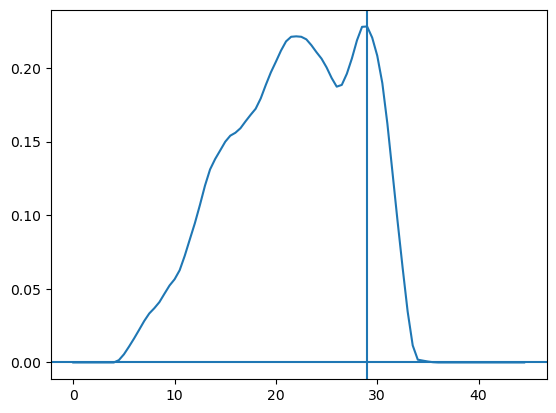

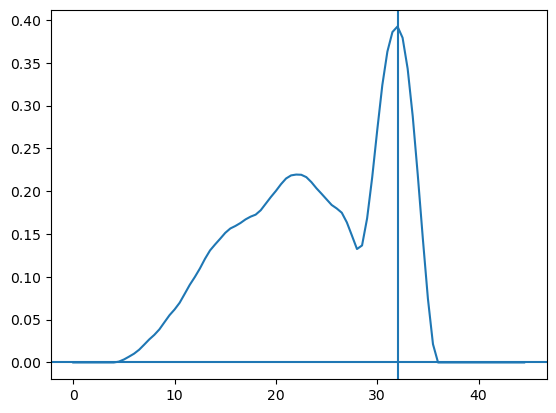

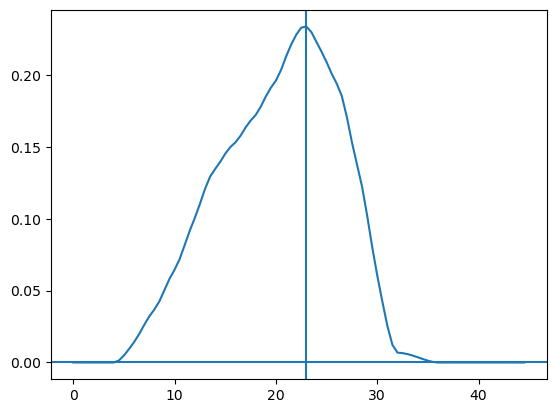

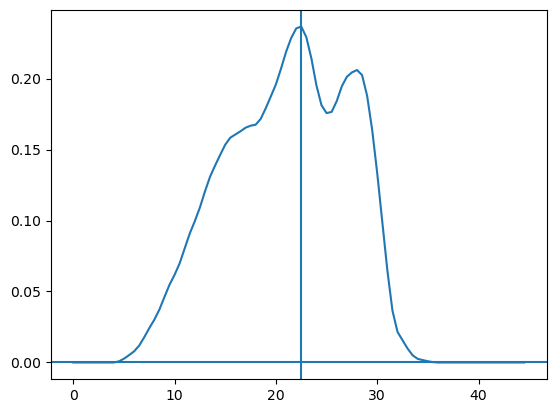

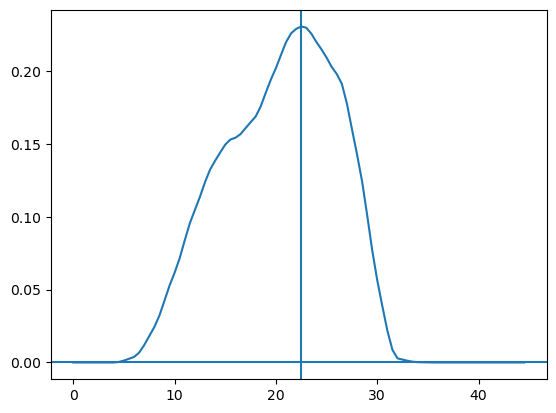

In [ ]:
bs = 500
n_channels = 1

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 1  # Example: 5 classes

epochs = 10

model_args = (input_dim, hidden_dim, num_layers, output_dim)
model_class = temp_response_learner

coeffs_list = fit_on_subsets(temp_series_DE, NDVI_labels_DE, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=False)

23.0


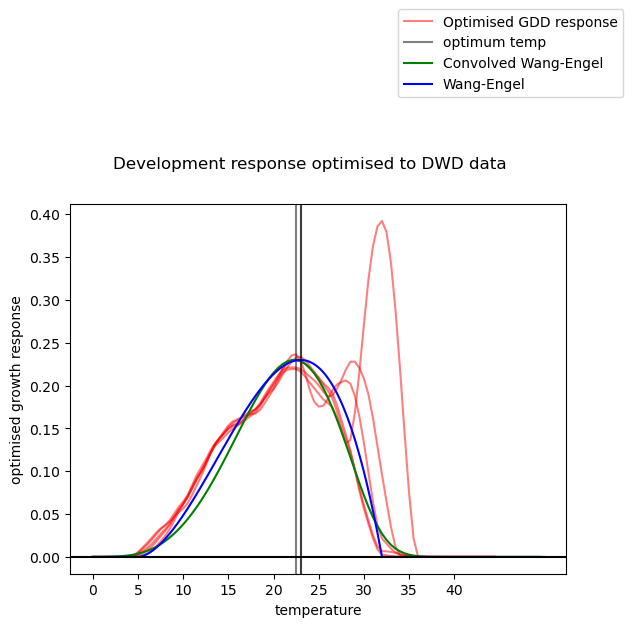

In [ ]:
table = vec_expint(7, 23.5, 30, np.arange(0, 50, 0.5), 2.5, 5)
unconvolved = modelling_fctns.Wang_Engel_Temp_response(np.arange(0, 50, 0.1), 5, 23, 32)
def B_0(u):
    return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)
fig, ax = plt.subplots()
for i, co in enumerate(coeffs_list):
    def response(meantemp):
        resp = 0
        for i, coeff in enumerate(co):
            resp += torch.abs(coeff)*B_0(0.25*(meantemp - i*2))
        return resp
    if i == 2:
        ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)), alpha = 0.5, color = 'red', label='Optimised GDD response')
        maxval = np.arange(0, 45, 0.5)[response(np.arange(0, 45, 0.5)).argmax()]
        print(maxval)
        ax.axvline(maxval, alpha = 0.5, color = 'black', label = 'optimum temp')
    else:
        ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)), alpha = 0.5, color = 'red')
    
ax.plot(np.arange(0, 50, 0.5), table*0.23/table.max(), color = 'green', label = 'Convolved Wang-Engel')
maxval = np.arange(0, 50, 0.5)[table.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black')
ax.plot(np.arange(0, 50, 0.1), unconvolved*0.23/unconvolved.max(), color = 'blue', label = 'Wang-Engel')
maxval = np.arange(0, 50, 0.1)[unconvolved.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black')
ax.axhline(0, color = 'black')
ax.set_xlabel('temperature')
ax.set_ylabel('optimised growth response')
ax.set_xticks(np.arange(0, 45, 5))
fig.suptitle('Development response optimised to DWD data')
fig.legend(bbox_to_anchor = (1, 1.3))


In [ ]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')
skip = 1
numsteps = int(163 // skip)
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_SSA = torch.Tensor((ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_SSA = torch.Tensor(ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]].values)#12
day_series_SSA = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1) #, photoperiod_series_SSA
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

0 38.876075744628906 38.650489807128906
5 38.33977508544922 38.11037826538086
10 38.30888748168945 38.0819091796875
15 37.76735305786133 37.536720275878906
20 37.7336311340332 37.504188537597656
25 37.643402099609375 36.955448150634766
30 37.146087646484375 36.920841217041016
35 36.59192657470703 36.36382293701172
40 36.545005798339844 36.31973648071289
45 35.98384475708008 35.75715637207031
50 35.414302825927734 35.186492919921875
55 35.34639358520508 34.609954833984375
60 34.76361083984375 34.02791976928711
65 34.110809326171875 33.433250427246094
70 33.065582275390625 32.8304443359375
75 32.44908905029297 32.036075592041016
80 31.298255920410156 31.055068969726562
85 30.12312126159668 29.83152961730957
90 28.75384521484375 28.14210319519043
95 26.69769859313965 26.188701629638672
100 24.281845092773438 23.51629638671875
105 21.038101196289062 19.952390670776367
110 16.17186164855957 14.725687980651855
115 8.919641494750977 6.813098907470703
120 2.011627674102783 1.1141560077667236
1

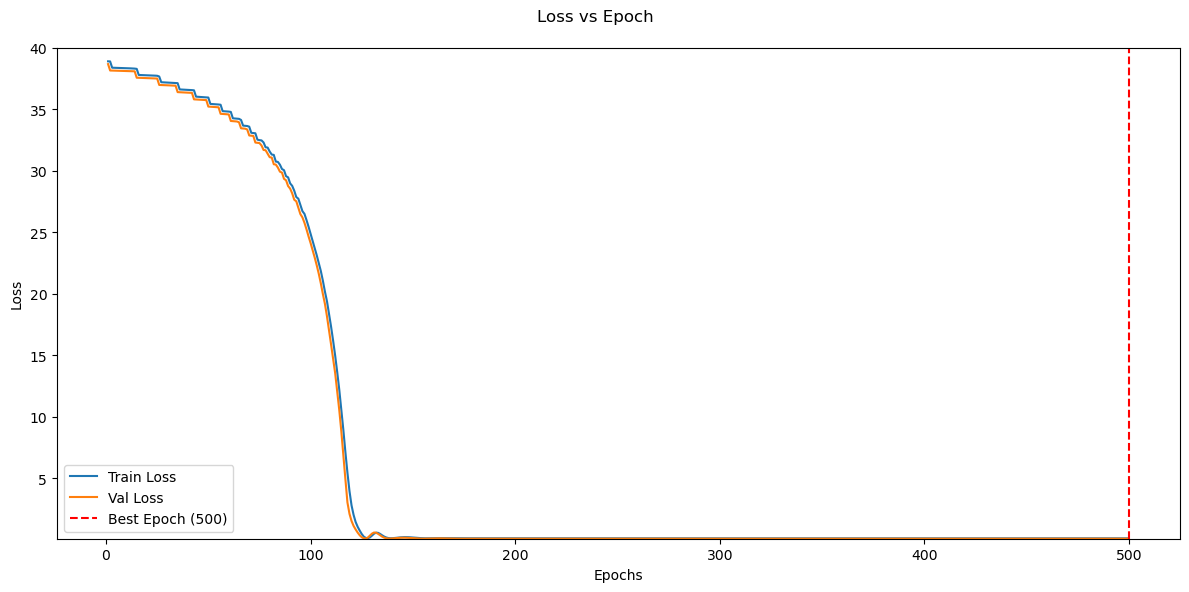

In [ ]:
bs = 500
n_channels = 1
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.95)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 32
num_layers = 2
output_dim = 1  # Example: 5 classes


save_name = 'temp_response_wang_SSA'

bce = True
CNN = False

model = temp_response_learner(input_dim, hidden_dim, num_layers, output_dim)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 500
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

In [ ]:
epochs = 50
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([0.])
u5 tensor([-0.0880])
u6 tensor([0.0054])
u7 tensor([0.0717])
u8 tensor([0.0809])
u9 tensor([0.0691])
u10 tensor([0.0756])
u11 tensor([0.0968])
u12 tensor([0.0902])
u13 tensor([0.1131])
u14 tensor([0.1124])
u15 tensor([0.0840])
u16 tensor([3.6280e-05])
u17 tensor([0.])
u18 tensor([0.])
u19 tensor([0.])
p0 tensor([13.8375])
27.0


Text(0.5, 0.98, 'Development response optimised to SSA data')

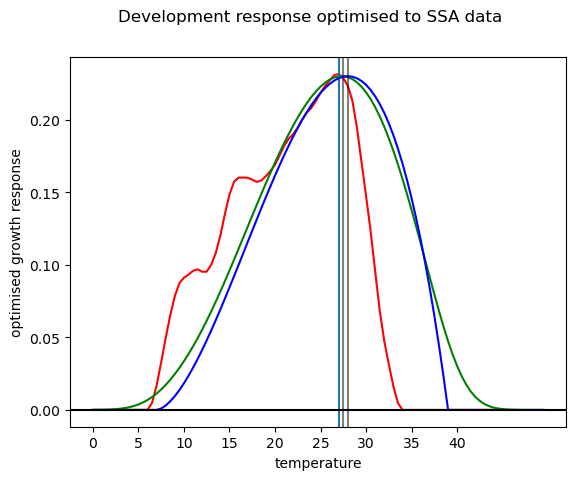

In [ ]:
coeffs = []
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        coeffs.append(param.data)
coeffs = coeffs[:-4]

def B_0(u):
    return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)

def response(meantemp):
    resp = 0
    for i, coeff in enumerate(coeffs):
        resp += torch.abs(coeff)*B_0(0.25*(meantemp - i*2))
    return resp
    
fig, ax = plt.subplots()
ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)), color = 'red', label = 'empirical response')
maxval = np.arange(0, 45, 0.5)[response(np.arange(0, 45, 0.5)).argmax()]
print(maxval)
ax.axvline(maxval)
ax.plot(np.arange(0, 50, 0.5), table*0.23/table.max(), color = 'green', label = 'Convolved Wang-Engel')
maxval = np.arange(0, 50, 0.5)[table.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black')
ax.plot(np.arange(0, 50, 0.5), unconvolved*0.23/unconvolved.max(), color = 'blue', label = 'Wang-Engel')
maxval = np.arange(0, 50, 0.5)[unconvolved.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black', label = 'optimum temperature')
ax.axhline(0, color = 'black')
ax.set_xlabel('temperature')
ax.set_ylabel('optimised growth response')
ax.set_xticks(np.arange(0, 45, 5))
fig.suptitle('Development response optimised to SSA data')